## Basic Model

Based on: https://github.com/ChristianMarzahl/ObjectDetection/blob/master/examples/CocoTiny_Retina_Net.ipynb

In [25]:
import os
import math
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor, tensor


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

from fastai.core import is_tuple
from fastai.train import ShowGraph
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer, Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar

In [37]:
#from RetinaNet.object_detection_helper import 
from RetinaNet.object_detection_helper import create_anchors, show_results_side_by_side
from RetinaNet.RetinaNetFocalLoss import FocalLoss
from RetinaNet.RetinaNet import RetinaNet
from RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [11]:
DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
ANNOTATIONS = DATA/'train_labelled_annotations'

In [12]:
def get_annotations_from_path(folderPath, prefix=None):
    "Open the files in folder `folderPath` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    filePaths = os.listdir(folderPath)     
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {}
    
    sorghumHeadCategory = 0
    
    for path in filePaths:
        fullPath = folderPath/path
        id = path.replace('.txt', '.jpeg')
        
        with open(fullPath, 'r') as f:
            for line in f:
                
                splitLines = line.split(' ')
                
                left = int(splitLines[1])
                top = int(splitLines[2])
                right = int(splitLines[3])
                bottom = int(splitLines[4].strip())
               
                id2bboxes[id].append([top, left, bottom, right])
                id2cats[id].append(sorghumHeadCategory)
               
            id2images[id] = IMAGES/id

    #Set up classes mapping from id to classname
    classes[sorghumHeadCategory] = 'sorghumHead'
                   
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]

In [13]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

In [14]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)

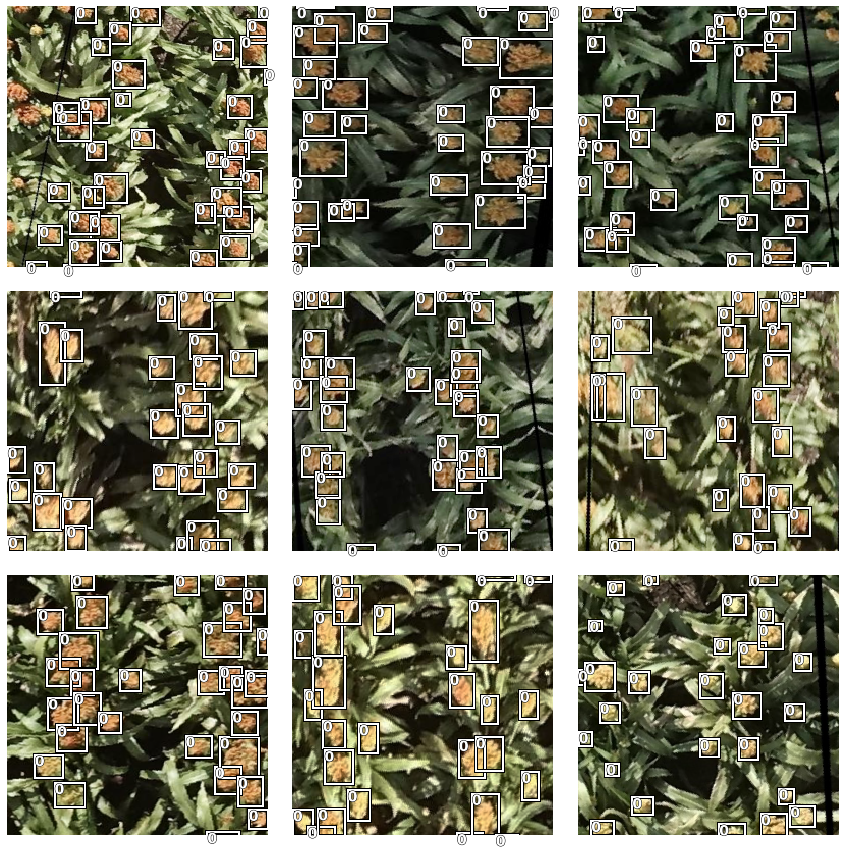

In [19]:
batch_size = 64
image_size = 256

data = get_data(batch_size, image_size)
data.show_batch(3)

In [20]:
#WARNING: Hardcoded anchor sizes probably not great for when we change things
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 1])

In [43]:
n_classes = data.train_ds.c

crit = FocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

In [44]:
voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [45]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.776040,1.873084,0.008678,0.519183,1.353901,0.008678,00:04
1,2.043506,1.501498,0.039194,0.491621,1.009878,0.039194,00:05
2,1.681008,1.281690,0.019455,0.466475,0.815215,0.019455,00:05
3,1.452843,1.108260,0.114678,0.443424,0.664836,0.114678,00:05
4,1.298398,1.031392,0.185123,0.419307,0.612085,0.185123,00:05
5,1.170867,0.955247,0.226600,0.396760,0.558487,0.226600,00:04
6,1.068084,0.888268,0.228860,0.344415,0.543853,0.228860,00:04
7,0.980189,0.797995,0.194408,0.364897,0.433098,0.194408,00:05
8,0.912257,0.787342,0.231066,0.325876,0.461466,0.231066,00:05
9,0.857914,0.788661,0.258228,0.371100,0.417561,0.258228,00:05


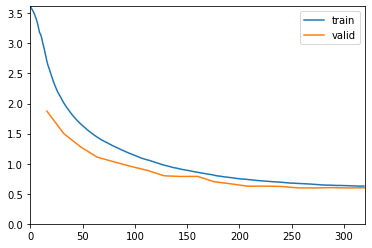

In [46]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,0.605698,0.605712,0.192671,0.268227,0.337485,0.192671,00:05
1,0.604351,0.600650,0.200556,0.267242,0.333408,0.200556,00:05
2,0.605774,0.598080,0.202659,0.265929,0.332151,0.202659,00:05
3,0.607718,0.597222,0.197128,0.264675,0.332547,0.197128,00:05
4,0.609569,0.597310,0.201109,0.264537,0.332773,0.201109,00:05
5,0.609849,0.592883,0.201408,0.263124,0.329760,0.201408,00:05
6,0.607175,0.597560,0.202311,0.264971,0.332589,0.202311,00:05
7,0.606355,0.593685,0.202905,0.262890,0.330795,0.202905,00:05
8,0.605293,0.592989,0.207459,0.263485,0.329504,0.207459,00:05
9,0.608626,0.590861,0.207105,0.263608,0.327253,0.207105,00:05


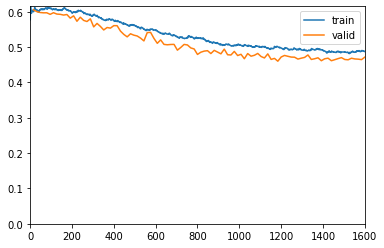

In [47]:
learn.unfreeze()
learn.fit_one_cycle(100, slice(1e-5, 1e-4))

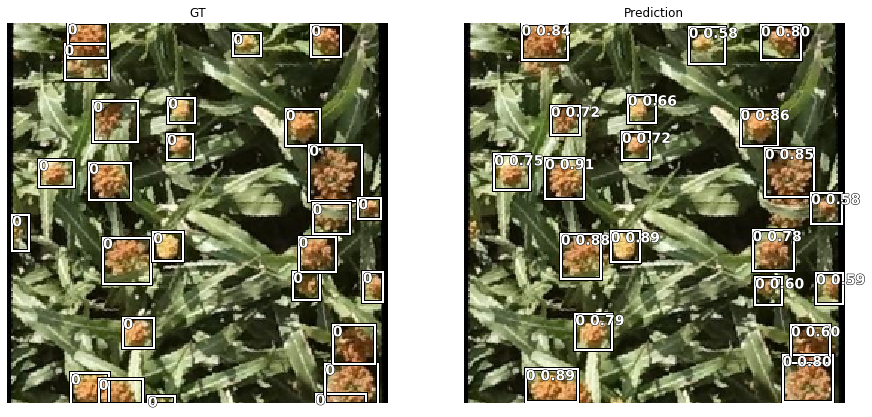

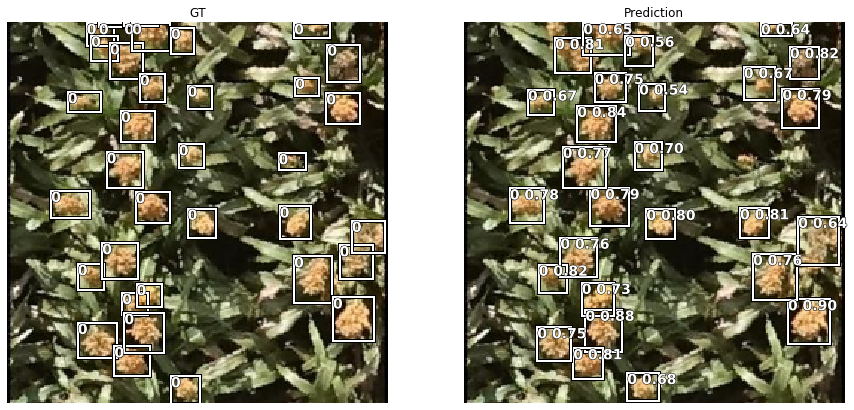

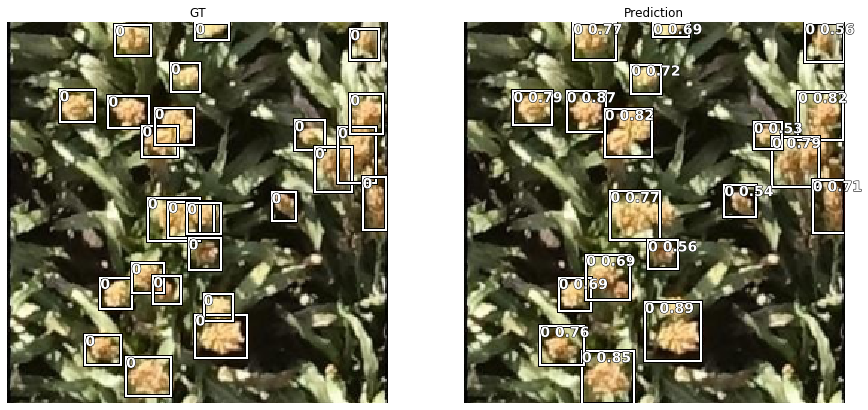

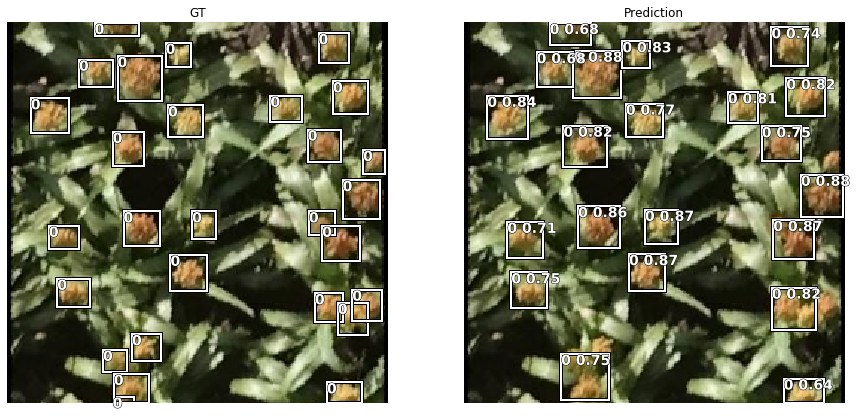

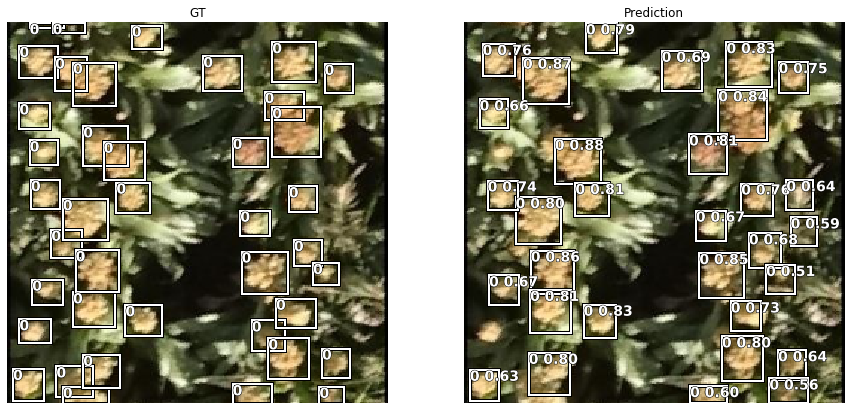

In [48]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)